In [5]:
# this is a modification to Stan's code to extract PI from MOT2. 
# changes: 
# 1. it finds the metadata file and reads it, uses information in the metadata to plot and annotate outputs 
# 2. it finds the last 30 seconds of arousal test (assuming there is only one arousal test episode) and computes
# the PI of that period
# 3. it plots arousal PI grouped by and colored by user defined categories (but see notes near the bottom).
# 4. future versions will also include: statitc test PI; arousal test PI for multiple episodes as in trace cond. 
# 5. future versions will be wrapped nicely in functions. 
# windows users should change the direction of the slashes i think

import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm as cm
import csv
import dabest
import seaborn as sns
%matplotlib inline

import os
currentPath = os.getcwd()
flagSwitchGenotype=False
##~~~~~~~~~~~~~~~~~ Windows users: Change the direction of slashes in the section below~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# the following line finds the sample data folder in the same folder as the code
# 2018-07-22-CS-Simultaneous-Green is an example of tests done with only CS files
# OK107Trace is an example of multiple sessions with 3 genotypes

# or user can define the path to data folder with the following line
datapath="/Users/xusy/Data/MOTSangyu/dump/2020-02-14_W1118Age/Trace"

startingChamberNumber=5



# # or user can define the path to data folder by uncommenting the following line
# datapath="/Users/xusy/Data/MOTRachel/ACRxOK107 trace conditioning"


experimentName=datapath.rsplit('/', 1)[-1]
if 1*("summary" in os.listdir(datapath))==0:
    os.mkdir(datapath + '/summary')
summaryFolderPath=datapath + '/summary/'
##~~~~~~~~~~~~~~~~~ Windows users: Change the direction of slashes in the section above~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

print (datapath)
filenames = os.listdir(datapath)
filenames.sort()
#finds the countlogs here
countlogs= [s for s in filenames if "CountLog" in s]
#finds the metadata files here
metadatas = [s for s in filenames if "MetaData" in s]

PIdfAllDay=[];
minStaticTestIndex=1
#proceses each countlog in alphabetical
for i in range(0, len(countlogs)):
    f = countlogs[i]
    m = 'MetaData'+ f[8:]
    df = pd.read_csv(datapath+'/'+f, error_bad_lines=False)
    dfMeta = pd.read_csv(datapath+'/'+m, error_bad_lines=False)

    #finds the bits in the countlogs that are arousal tests
    arousalTestIndex=[i for i, e in enumerate(df.ExperimentState) if "Arousal" in e]
    #picks out the last 30 data points (which at 1fps is 30 seconds) in future versions this should be made a function of framerate
    lastArousalTime = df.loc[arousalTestIndex[-1]].Seconds-30
    absDiffArousalTime = np.absolute(df.loc[arousalTestIndex].Seconds-lastArousalTime)
    start30SecondArousalIdx = absDiffArousalTime.idxmin(skipna=True)
    last30secArousal = df.loc[start30SecondArousalIdx: arousalTestIndex[-1]]
    PIArousalAll=last30secArousal.filter(regex= "Ch"+str(startingChamberNumber+1)+"_PI_r")
    
    for chamber in range(startingChamberNumber+1, 15):
        last30secArousalDF = last30secArousal.filter(regex= "Ch"+str(chamber)+"_PI_r")
        PIArousalAll["Ch"+str(chamber)+"_PI_r"] =last30secArousalDF.values    
    PIallArousalAverage = PIArousalAll.mean(axis=0)
    PIallArousalAverage.values[np.flatnonzero(1*dfMeta.Odor[startingChamberNumber:15]=='MCH')] = 0- PIallArousalAverage.values[np.flatnonzero(1*dfMeta.Odor[startingChamberNumber:15]=='MCH')]

    GenotypeList=['Control Gal4', 'Control UAS', 'Test', 'W1118']
    GenotypeNumber = 1*dfMeta.Genotype.str.contains('Gal4')+2*dfMeta.Genotype.str.contains('UAS')+4*dfMeta.Genotype.str.contains('CS')    
    PIresults={'Chambers':dfMeta.ID[startingChamberNumber:15], 'Run':str(i+1), 'Odor':dfMeta.Odor[startingChamberNumber:15], 'ISI':dfMeta.ISI[startingChamberNumber:15],
               'Arousal PI':PIallArousalAverage.values.T,  
               'Genotype':dfMeta.Genotype[startingChamberNumber:15], 'GenotypeNumber':GenotypeNumber[startingChamberNumber:15], 'Date': f[9:-4]}

#     #finds the bits in the countlogs that are arousal tests
#     staticTestIndex=[i for i, e in enumerate(df.ExperimentState) if "Static" in e]
#     if len(staticTestIndex) !=0:
#         #picks out the last 30 data points (which at 1fps is 30 seconds) in future versions this should be made a function of framerate
#         last30secStatic = df.loc[staticTestIndex[-30:]]
#         lastStaticTime = df.loc[staticTestIndex[-1]].Seconds-30
#         absDiffStaticTime = np.absolute(df.loc[staticTestIndex].Seconds-lastStaticTime)
#         start30SecondStaticIdx = absDiffStaticTime.idxmin(skipna=True)
#         last30secArousal = df.loc[start30SecondStaticIdx: staticTestIndex[-1]]
# #         PIStaticAll=last30secStatic.filter(regex= "Ch"+str(5)+"_PI_r")

#         for chamber in range(6, 15):        
#             last30secStaticDF = last30secStatic.filter(regex= "Ch"+str(chamber)+"_PI_r")
# #             PIStaticAll["Ch"+str(chamber)+"_PI_r"] =last30secStaticDF.values
# #         PIallStaticAverage = PIStaticAll.mean(axis=0)
# #         PIallStaticAverage.values[np.flatnonzero(1*dfMeta.Odor[4:15]=='MCH')] = 0- PIallStaticAverage.values[np.flatnonzero(1*dfMeta.Odor[4:15]=='MCH')]
#         PIresults={'Chambers':np.arange(5,15), 'Run':str(i+1), 'Odor':dfMeta.Odor[4:15],
#                'Corrected Arousal PI':PIallArousalAverage.values.T,  
#                'Genotype':dfMeta.Genotype[4:15], 'GenotypeNumber':GenotypeNumber[4:15], 'Corrected Static PI':PIallStaticAverage.values.T}
    PIdf=pd.DataFrame(data=PIresults)
    PIdf.index=range(1, len(PIdf)+1)
   


    GenotypeCorrected=[GenotypeList[PIdf.loc[i].GenotypeNumber-1] for i in range(1, len(PIdf)+1)]
    PIdf=PIdf.assign(GenotypeCorrected = GenotypeCorrected)        
    PIdf=PIdf.drop(['GenotypeNumber'], axis=1)
    # the following lines save the average and raw PIs as .csv into a folder called 'summary' created in the original data folder
    PIdf.to_csv(summaryFolderPath + 'averagePI' + f[8:-4] + '.csv', sep=',', index=True, index_label = None)
    PIArousalAll.to_csv(summaryFolderPath + 'arousalRawPI'+ f[8:-4] + '.csv', sep=',', index=True)
#     PIStaticAll.to_csv(summaryFolderPath + 'staticRawPI'+ f[8:-4] + '.csv', sep=',', index=True)
    PIdfAllDay.append(PIdf)
    print(f)
    print(PIdf)
    print('Mean PI' + str(np.mean(PIallArousalAverage.values.T)))
#     minStaticTestIndex = np.min([minStaticTestIndex, len(staticTestIndex)])
PIdfAllDay=pd.concat(PIdfAllDay)
PIdfAllDay.index=range(1, len(PIdfAllDay)+1)
PIdfAllDay['Chambers']=PIdfAllDay['Chambers']*0.1
PIdfAllDay['Chambers']=PIdfAllDay['Chambers'].apply(str)
PIdfAllDay['Chambers']=PIdfAllDay.Chambers.str[0]+PIdfAllDay.Chambers.str[2]
PIdfAllDay['ISI']=PIdfAllDay['ISI'].apply(str)



if flagSwitchGenotype:
    uniqueGenotypeIdx=np.unique(PIdfAllDay.GenotypeCorrected, return_index=True)[1]
    GenotypeLabels=[PIdfAllDay.loc[j+1].GenotypeCorrected for j in uniqueGenotypeIdx]
    genotypeToUse='GenotypeCorrected'
else:
    GenotypeLabels=np.unique(PIdfAllDay.Genotype)
    genotypeToUse='Genotype'

uniqueRunIdx=np.unique(PIdfAllDay.Run, return_index=True)[1]
RunLabels=[PIdfAllDay.loc[k+1].Run for k in uniqueRunIdx]
uniqueOdorIdx=np.unique(PIdfAllDay.Odor, return_index=True)[1]
odorLabels=[PIdfAllDay.loc[j+1].Odor for j in uniqueOdorIdx]
    
# if minStaticTestIndex !=0:
#     if len(GenotypeLabels)>1: # if there are different genotypes in the metadata, more commonly encountered in tests
#         StaticFig, StaticB = dabest.plot(PIdfAllDay,
#                                x=genotypeToUse, # the default for this test config is to group flies by genotype
#                                y='Corrected Static PI',
#                                color_col='Odor',# and color by odor
#                                swarm_ylim =(-1.5,1.5),
#                                fig_size=(4,6),
#                                idx=GenotypeLabels,
#                                paired=False
#                               )
#     else: # if there is only one genotype in the metadata, commonly encountered if just test equipment with CS flies
#         StaticFig, StaticB = dabest.plot(PIdfAllDay,
#                                x='Odor', # if just one type of flies, group by odor. This can also be "Run" 
#                                           #which is the session/file in chronological sequence
#                                y='Corrected Static PI',
#                                swarm_ylim =(-1.5,1.5),
#                                fig_size=(4,6),
#                                idx=odorLabels, # this has to correspond to the value of x above. if x is 'Run', idx has to be 'RunLabels'
#                                paired=False
#                               )
#     # print(b)
#     plt.title(experimentName + 'Static Test')   
# plt.savefig(summaryFolderPath+ 'StaticContrast' + f[8:-4] + '.png', bbox_inches='tight', dpi = 300)


# if len(GenotypeLabels)>1: # if there are different genotypes in the metadata, more commonly encountered in tests
#     ArousalB, ArousalB = dabest.plot(PIdfAllDay,
#                            x='Run', # the default for this test config is to group flies by genotype
#                            y='Corrected Arousal PI',
#                            color_col='Genotype',# and color by odor
#                            swarm_ylim =(-1.5,1.5),
#                            fig_size=(10,3),
#                            idx=RunLabels,
#                            paired=False
#                           )
# else: # if there is only one genotype in the metadata, commonly encountered if just test equipment with CS flies
#     ArousalB, ArousalB = dabest.plot(PIdfAllDay,
#                            x='Run', # if just one type of flies, group by odor. This can also be "Run" 
#                                       #which is the session/file in chronological sequence
#                            y='Corrected Arousal PI',
#                            swarm_ylim =(-1.5,1.5),
#                            fig_size=(10,3),
#                            idx=RunLabels, # this has to correspond to the value of x above. if x is 'Run', idx has to be 'RunLabels'
#                            paired=False
#                           )
# plt.title(experimentName + 'Arousal Test')   
# # print(b)
# # the following line saves the figure into a folder called 'summary' created in the original data folder
# plt.savefig(summaryFolderPath+ 'ArousalContrast' + f[8:-4] + '.png', bbox_inches='tight', dpi = 300)



/Users/xusy/Data/MOTSangyu/dump/2020-02-14_W1118Age/Trace


/Users/xusy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


CountLog_2020-02-14_13-51-44.csv
   Chambers Run Odor   ISI  Arousal PI Genotype                 Date  \
1         6   1  OCT  10.0   -0.661290    W1118  2020-02-14_13-51-44   
2         7   1  OCT  10.0   -0.803226    W1118  2020-02-14_13-51-44   
3         8   1  OCT  10.0   -0.129032    W1118  2020-02-14_13-51-44   
4         9   1  OCT  10.0    0.901161    W1118  2020-02-14_13-51-44   
5        10   1  OCT  10.0   -0.192484    W1118  2020-02-14_13-51-44   
6        11   1  OCT  10.0    0.636000    W1118  2020-02-14_13-51-44   
7        12   1  OCT  10.0    1.000000    W1118  2020-02-14_13-51-44   
8        13   1  OCT  10.0    0.819355    W1118  2020-02-14_13-51-44   
9        14   1  OCT  10.0    0.790355    W1118  2020-02-14_13-51-44   

  GenotypeCorrected  
1             W1118  
2             W1118  
3             W1118  
4             W1118  
5             W1118  
6             W1118  
7             W1118  
8             W1118  
9             W1118  
Mean PI0.26231541218638


In [10]:
odorLabels

['OCT']

UnboundLocalError: local variable 'current_control' referenced before assignment

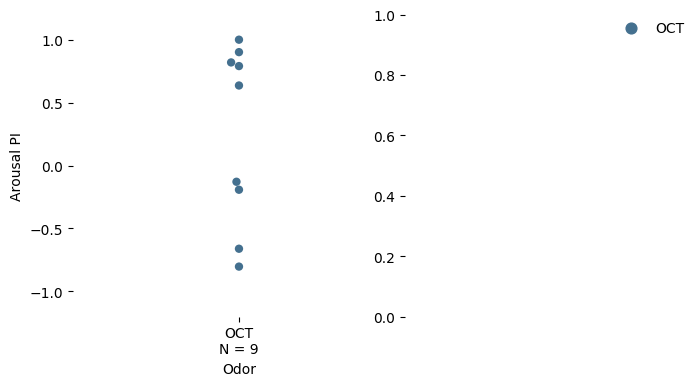

In [9]:
flagOdor=False
flagISI=True

ISIRange=['30.0']
OdorRange=['MCH', 'OCT']

PIdfAllDay0=PIdfAllDay


PIdfAllDay0=PIdfAllDay.loc[PIdfAllDay['Genotype']!='CS']
PIdfAllDay0=PIdfAllDay0.loc[PIdfAllDay0['Genotype']!='MB247-Gal4; W1118']
PIdfAllDay0=PIdfAllDay0.loc[PIdfAllDay0['Genotype']!='MB247-Gal4>UAS-ACR1']
PIdfAllDay0=PIdfAllDay0.loc[PIdfAllDay0['Genotype']!='W1118; UAS-ACR1 (MB247)']



# PIdfAllDay0=PIdfAllDay0.loc[PIdfAllDay0['Genotype']!='GH146-Gal4; W1118']
# PIdfAllDay0=PIdfAllDay0.loc[PIdfAllDay0['Genotype']!='GH146-Gal4>UAS-ACR1']
# PIdfAllDay0=PIdfAllDay0.loc[PIdfAllDay0['Genotype']!='W1118; UAS-ACR1 (GH146)']
if len(GenotypeLabels)>1: # if there are different genotypes in the metadata, more commonly encountered in tests
    ArousalB = dabest.load(PIdfAllDay,
                           x='Genotype', # the default for this test config is to group flies by genotype
                           y='Arousal PI',
                           idx=GenotypeLabels,
                           paired=False
                          )
    
    fAraousalB = ArousalB.mean_diff.plot(
                           swarm_label='Half Arousal PI',
                           contrast_label='Mean Diff',
                           color_col='Odor',# and color by odor
                           swarm_ylim =(-1.2,1.2),
                           fig_size=(6,4))
else: # if there is only one genotype in the metadata, commonly encountered if just test equipment with CS flies
    ArousalB = dabest.load(PIdfAllDay,
                           x='Odor', # if just one type of flies, group by odor. This can also be "Run" 
                                      #which is the session/file in chronological sequence
                           y='Arousal PI',
                           idx=odorLabels, # this has to correspond to the value of x above. if x is 'Run', idx has to be 'RunLabels'
                           paired=False
                          )
    
    fArousalB = ArousalB.mean_diff.plot(
                          swarm_label='Half Arousal PI',
                        contrast_label='Mean Diff',
                            color_col='Odor',# and color by odor
                           swarm_ylim =(-1.2,1.2),
                           fig_size=(6,4))
    
    
plt.title(experimentName + ' Arousal Test')   





# for Odor in OdorRange:
#     if flagOdor:
#         PIdfAllDay1=PIdfAllDay0.loc[PIdfAllDay0['Odor']==Odor]
#     else:
#         PIdfAllDay1=PIdfAllDay0
#     for ISI in ISIRange:
#         if flagISI:
#             PIdfAllDay2=PIdfAllDay1.loc[PIdfAllDay1['ISI']==ISI]
#         else:
#             PIdfAllDay2=PIdfAllDay1
#         if flagSwitchGenotype:
#             uniqueGenotypeIdx=np.unique(PIdfAllDay2.GenotypeCorrected, return_index=True)[1]
#             GenotypeLabels=[PIdfAllDay2.loc[j+1].GenotypeCorrected for j in uniqueGenotypeIdx]
#             genotypeToUse='GenotypeCorrected'
#         else:
#             GenotypeLabels=np.unique(PIdfAllDay2.Genotype)
#             genotypeToUse='Genotype'

#         # uniqueRunIdx=np.unique(PIdfAllDay1.Run, return_index=True)[1]
#         # RunLabels=[PIdfAllDay1.loc[k+1].Run for k in uniqueRunIdx]
#         # uniqueOdorIdx=np.unique(PIdfAllDay1.Odor, return_index=True)[1]
#         # odorLabels=[PIdfAllDay1.loc[j].Odor for j in uniqueOdorIdx]

#         RunLabels=np.unique(PIdfAllDay2.Run)
# #         OdorLabels=np.unique(PIdfAllDay2.Odor)

#         OdorLabels=['OCT', 'MCH']

#         ChamberLabels=np.unique(PIdfAllDay2.Chambers)
#         ISILabels=np.unique(PIdfAllDay2.ISI)



#         if len(GenotypeLabels)>1: # if there are different genotypes in the metadata, more commonly encountered in tests
#              ArousalA, ArousalB = dabest.plot(PIdfAllDay2,
#                                     x='Chambers', # the default for this test config is to group flies by genotype
#                                     y='Arousal PI',
#                                     color_col='Odor',# and color by odor
#                                     swarm_ylim =(-1.5,1.5),
#                                     fig_size=(8, 6),
#                                     idx=ChamberLabels,
#                                     paired=False,
# #                                     custom_palette=[ 'darkorange',  'steelblue']
#                                     custom_palette=[ 'steelblue', 'darkorange' ]

#                                     )
#         else: # if there is only one genotype in the metadata, commonly encountered if just test equipment with CS flies
#             ArousalA, ArousalB = dabest.plot(PIdfAllDay2,
#                                     x='Chambers', # if just one type of flies, group by odor. This can also be "Run" 
#                                                   #which is the session/file in chronological sequence
#                                     y='Arousal PI',
#                                     color_col='Odor',# and color by odor
#                                     swarm_ylim =(-1.5,1.5),
#                                     fig_size=(8, 6),

# #                                     custom_palette=[ 'darkorange', 'steelblue'],
#                                     custom_palette=[ 'steelblue', 'darkorange' ],


#                                     idx=ChamberLabels, # this has to correspond to the value of x above. if x is 'Run', idx has to be 'RunLabels'
#                                     paired=False
#                                       )
#         plt.title(experimentName + ' Arousal Test ISI = '+str(ISI))   
#             # print(b)
#             # the following line saves the figure into a folder called 'summary' created in the original data folder
#         plt.savefig(summaryFolderPath+ 'ArousalContrast_ISI_'+str(ISI)+'_'+str(Odor) + '_flagOdor'+str(flagOdor)+ '_flagISI'+str(flagISI)+ f[8:-4] + '.png', bbox_inches='tight', dpi = 300)

#         print(ArousalB)

In [334]:
PIdfAllDay.to_csv(summaryFolderPath + 'AllPI' + '.csv', sep=',', index=True, index_label = None)



In [2]:
PIdfAllDay

[]

1     0
2     0
3     0
4     0
5     0
6     1
7     1
8     1
9     1
10    1
Name: Chambers, dtype: object

In [327]:
PIdfAllDay.loc[PIdfAllDay['Genotype']=='W1118; UAS-ACR1']

,Chambers,Run,Odor,ISI,Arousal PI,Genotype,Date,GenotypeCorrected
51,05,6,OCT,30.0,-0.209581,W1118; UAS-ACR1,2019-02-07_15-07-01,Control UAS
52,06,6,OCT,30.0,-0.477419,W1118; UAS-ACR1,2019-02-07_15-07-01,Control UAS
53,07,6,OCT,30.0,-0.703226,W1118; UAS-ACR1,2019-02-07_15-07-01,Control UAS
54,08,6,OCT,30.0,-0.424710,W1118; UAS-ACR1,2019-02-07_15-07-01,Control UAS
55,09,6,OCT,30.0,-0.107484,W1118; UAS-ACR1,2019-02-07_15-07-01,Control UAS
56,10,6,OCT,30.0,0.211613,W1118; UAS-ACR1,2019-02-07_15-07-01,Control UAS
57,11,6,OCT,30.0,0.277444,W1118; UAS-ACR1,2019-02-07_15-07-01,Control UAS
58,12,6,OCT,30.0,0.495935,W1118; UAS-ACR1,2019-02-07_15-07-01,Control UAS
59,13,6,OCT,30.0,0.314968,W1118; UAS-ACR1,2019-02-07_15-07-01,Control UAS
60,14,6,OCT,30.0,0.489161,W1118; UAS-ACR1,2019-02-07_15-07-01,Control UAS
